# Testing Navier-Stokes with a moving body in package `ViscousFlow`

In [1]:
using ViscousFlow

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Solve flow past a moving body

Set the flow parameters

In [3]:
Re = 200; # Reynolds number
U = 0.0; # Free stream velocity
U∞ = (U,0.0);

Set up points on the body

In [4]:
n = 51;
a = 0.5; b = 0.1;
body = Bodies.Plate(1.0,n)

Plate with 51 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


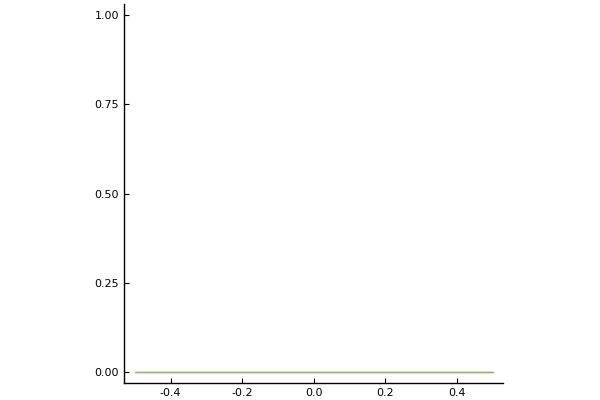

In [5]:
plot(body)

Set the motion to oscillatory pitch-heave kinematics

In [6]:
a = 0.25 # location of pitch axis, a = 0.5 is leading edge
ϕ = -π/2  # phase lag of pitch to heave
A = 0.25  # amplitude/chord
fstar = 1/π # fc/U
α₀ = 0 # mean angle of attack
Δα = 0.0 #10π/180 # amplitude of pitching
U₀ = 0.0 # translational motion (set to zero in place of free stream)

K = π*fstar # reduced frequency, K = πfc/U

oscil = RigidBodyMotions.PitchHeave(U₀,a,K,ϕ,α₀,Δα,A);
motion = RigidBodyMotion(oscil)

Rigid Body Motion:
  ċ = 0.0 + 0.5im
  c̈ = 0.0 + 0.0im
  α̇ = 0.0
  α̈ = -0.0
  Oscillatory pitch-heave kinematics with
     Reduced frequency K = 1.0
     Heaving amplitude A = 0.25
     Pitching amplitude Δα = 0.0
     Pitch-to-heave lag ϕ = -1.5707963267948966


In [7]:
motion(0.0)

(-0.25 + 0.0im, 0.0 + 0.5im, 0.0 + 0.0im, 0.0, 0.0, -0.0)

Transform the body with a specified initial position and orientation.

In [8]:
cent = 0.0 + 0.0im
α = 0.0
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration

Plate with 51 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


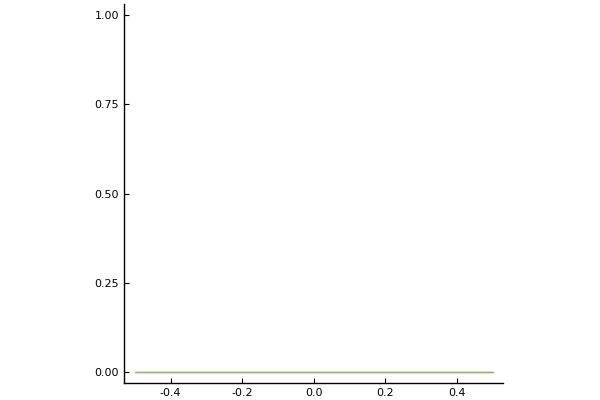

In [9]:
plot(body)

In [10]:
xlim = (-1.0,1.0)
ylim = (-1.0,1.0)

(-1.0, 1.0)

Now set up the coordinate data for operator construction

In [11]:
X = VectorData(body.x,body.y);
X̃ = VectorData(body.x̃,body.ỹ);

Set the domain size and time step size

In [12]:
Δx = 0.02;
Δt = min(0.5*Δx,0.5*Δx^2*Re);

### Now start constructing operators

#### Set up the state vector and constraint force vector for a moving body

In [13]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt,U∞ = U∞, X̃ = X̃, isstore = true, isstatic = false)

Navier-Stokes system on a grid of size 102 x 102

Set up solution data

In [14]:
w₀ = Nodes(Dual,size(sys));
u = (w₀,[real(cent),imag(cent),α])
xg, yg = coordinates(w₀,dx=Δx,I0=Systems.origin(sys))
f = (VectorData(X̃),Vector{Float64}());

In [17]:
using LinearAlgebra
plan_intfact1(t,u) = Fields.plan_intfact(t,u,sys)
plan_intfact2(t,u) = I
plans = (plan_intfact1,plan_intfact2)    

(plan_intfact1, plan_intfact2)

In [18]:
function TimeMarching.plan_constraints(u::Tuple{Nodes{Dual,NX,NY},Vector{Float64}},t,sys::NavierStokes{NX,NY,N,false}) where {NX,NY,N}

  # for now, just assume that there is only one body. will fix later.

  xc, yc, α = u[2]
  T = Bodies.RigidTransform((xc,yc),α)
  # should be able to save some time and memory allocation here...
  x, y = T(sys.X̃.u,sys.X̃.v)
  X = VectorData(x,y)
  regop = Regularize(X,cellsize(sys);issymmetric=true,I0=origin(sys))
  if sys._isstore
    Hmat, Emat = RegularizationMatrix(regop,VectorData{N}(),Edges{Primal,NX,NY}())
      
    sys.Hmat = Hmat
    sys.Emat = Emat
    
    return (f->TimeMarching.B₁ᵀ(f,sys), f->zeros(Float64,size(u[2]))),
           (w->TimeMarching.B₂(w,sys), u->Vector{Float64}())
  else
    return (f->TimeMarching.B₁ᵀ(f,regop,sys), f->zeros(Float64,size(u[2]))),
           (w->TimeMarching.B₂(w,regop,sys), u->Vector{Float64}())
  end


end

In [21]:
plan_constraints(u,t) = TimeMarching.plan_constraints(u,t,sys)
TimeMarching.r₁(u,t) = TimeMarching.r₁(u,t,sys,motion)
TimeMarching.r₂(u,t) = TimeMarching.r₂(u,t,sys,motion)
ifherk = IFHERK(u,f,sys.Δt,
                plans,plan_constraints,
                (TimeMarching.r₁,TimeMarching.r₂),tol=1e-3,rk=TimeMarching.RK31,isstored=true,isstaticconstraints=false)

Order-3 IF-HERK integrator with
   State of type Tuple{Nodes{Dual,102,102},Array{Float64,1}}
   Force of type Tuple{VectorData{51},Array{Float64,1}}
   Time step size 0.01


In [22]:
t = 0.0
w₀ .= 0.0
u = (deepcopy(w₀),[real(cent),imag(cent),α])
f = (VectorData(X̃),Vector{Float64}());
tf = 0.1;
T = Δt:Δt:tf;
fx = Float64[];
fy = Float64[];
thist = [];
uhist = [];
tsample = 0.1;

In [30]:
@time for ti in T
    global t, u, f = ifherk(t,u)
    
    # save data for later use
    push!(thist,t)
    push!(fx,sum(f[1].u)*Δx^2)
    push!(fy,sum(f[1].v)*Δx^2)
    (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(uhist,u) : nothing
end
println("solution completed through time t = ",t)

  5.386413 seconds (21.11 M allocations: 2.233 GiB, 6.01% gc time)
solution completed through time t = 0.3000000000000001


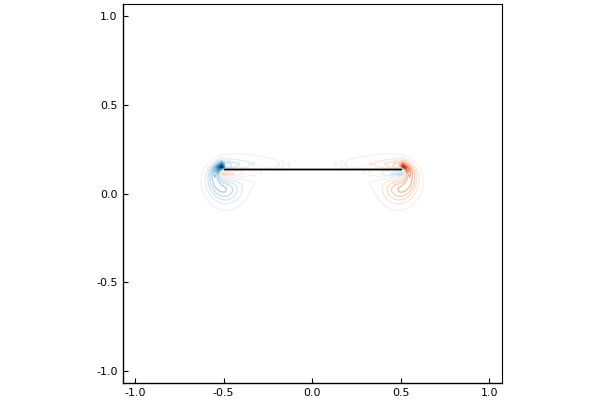

In [31]:
plot(xg,yg,uhist[end][1],levels=range(-1,1,length=30),color = :RdBu,clim=(-1,1))
Tr = RigidTransform(uhist[1][2])
Tr(body) # transform the body to the current configuration
plot!(body,linecolor=:black)

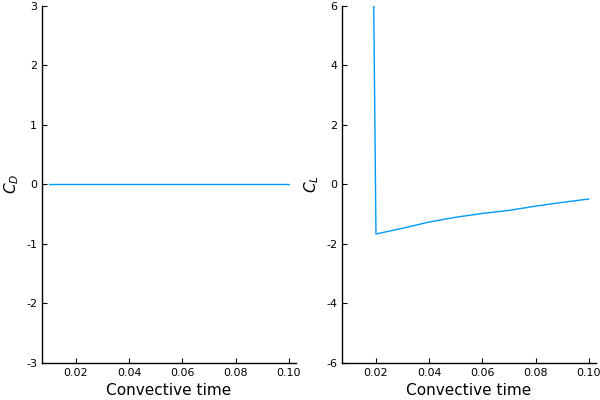

In [25]:
px = plot(thist,2*fx,ylim=(-3,3),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(-6,6),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

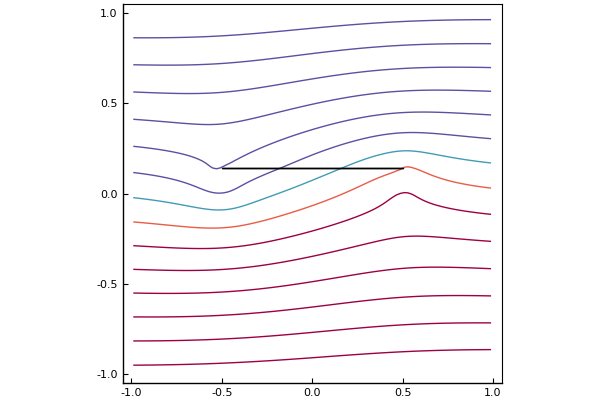

In [32]:
ψ = deepcopy(u[1])
ψ .= -(sys.L\u[1])*Δx .+ yg'
plot(xg,yg,ψ,trim=1,clim=(-0.1,0.1))
plot!(body,fillcolor=:black,linecolor=:black)